In [15]:
import pandas as pd
import numpy as np
import pprint as pp
import pgeocode as pg
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
import datetime

warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('train_2.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


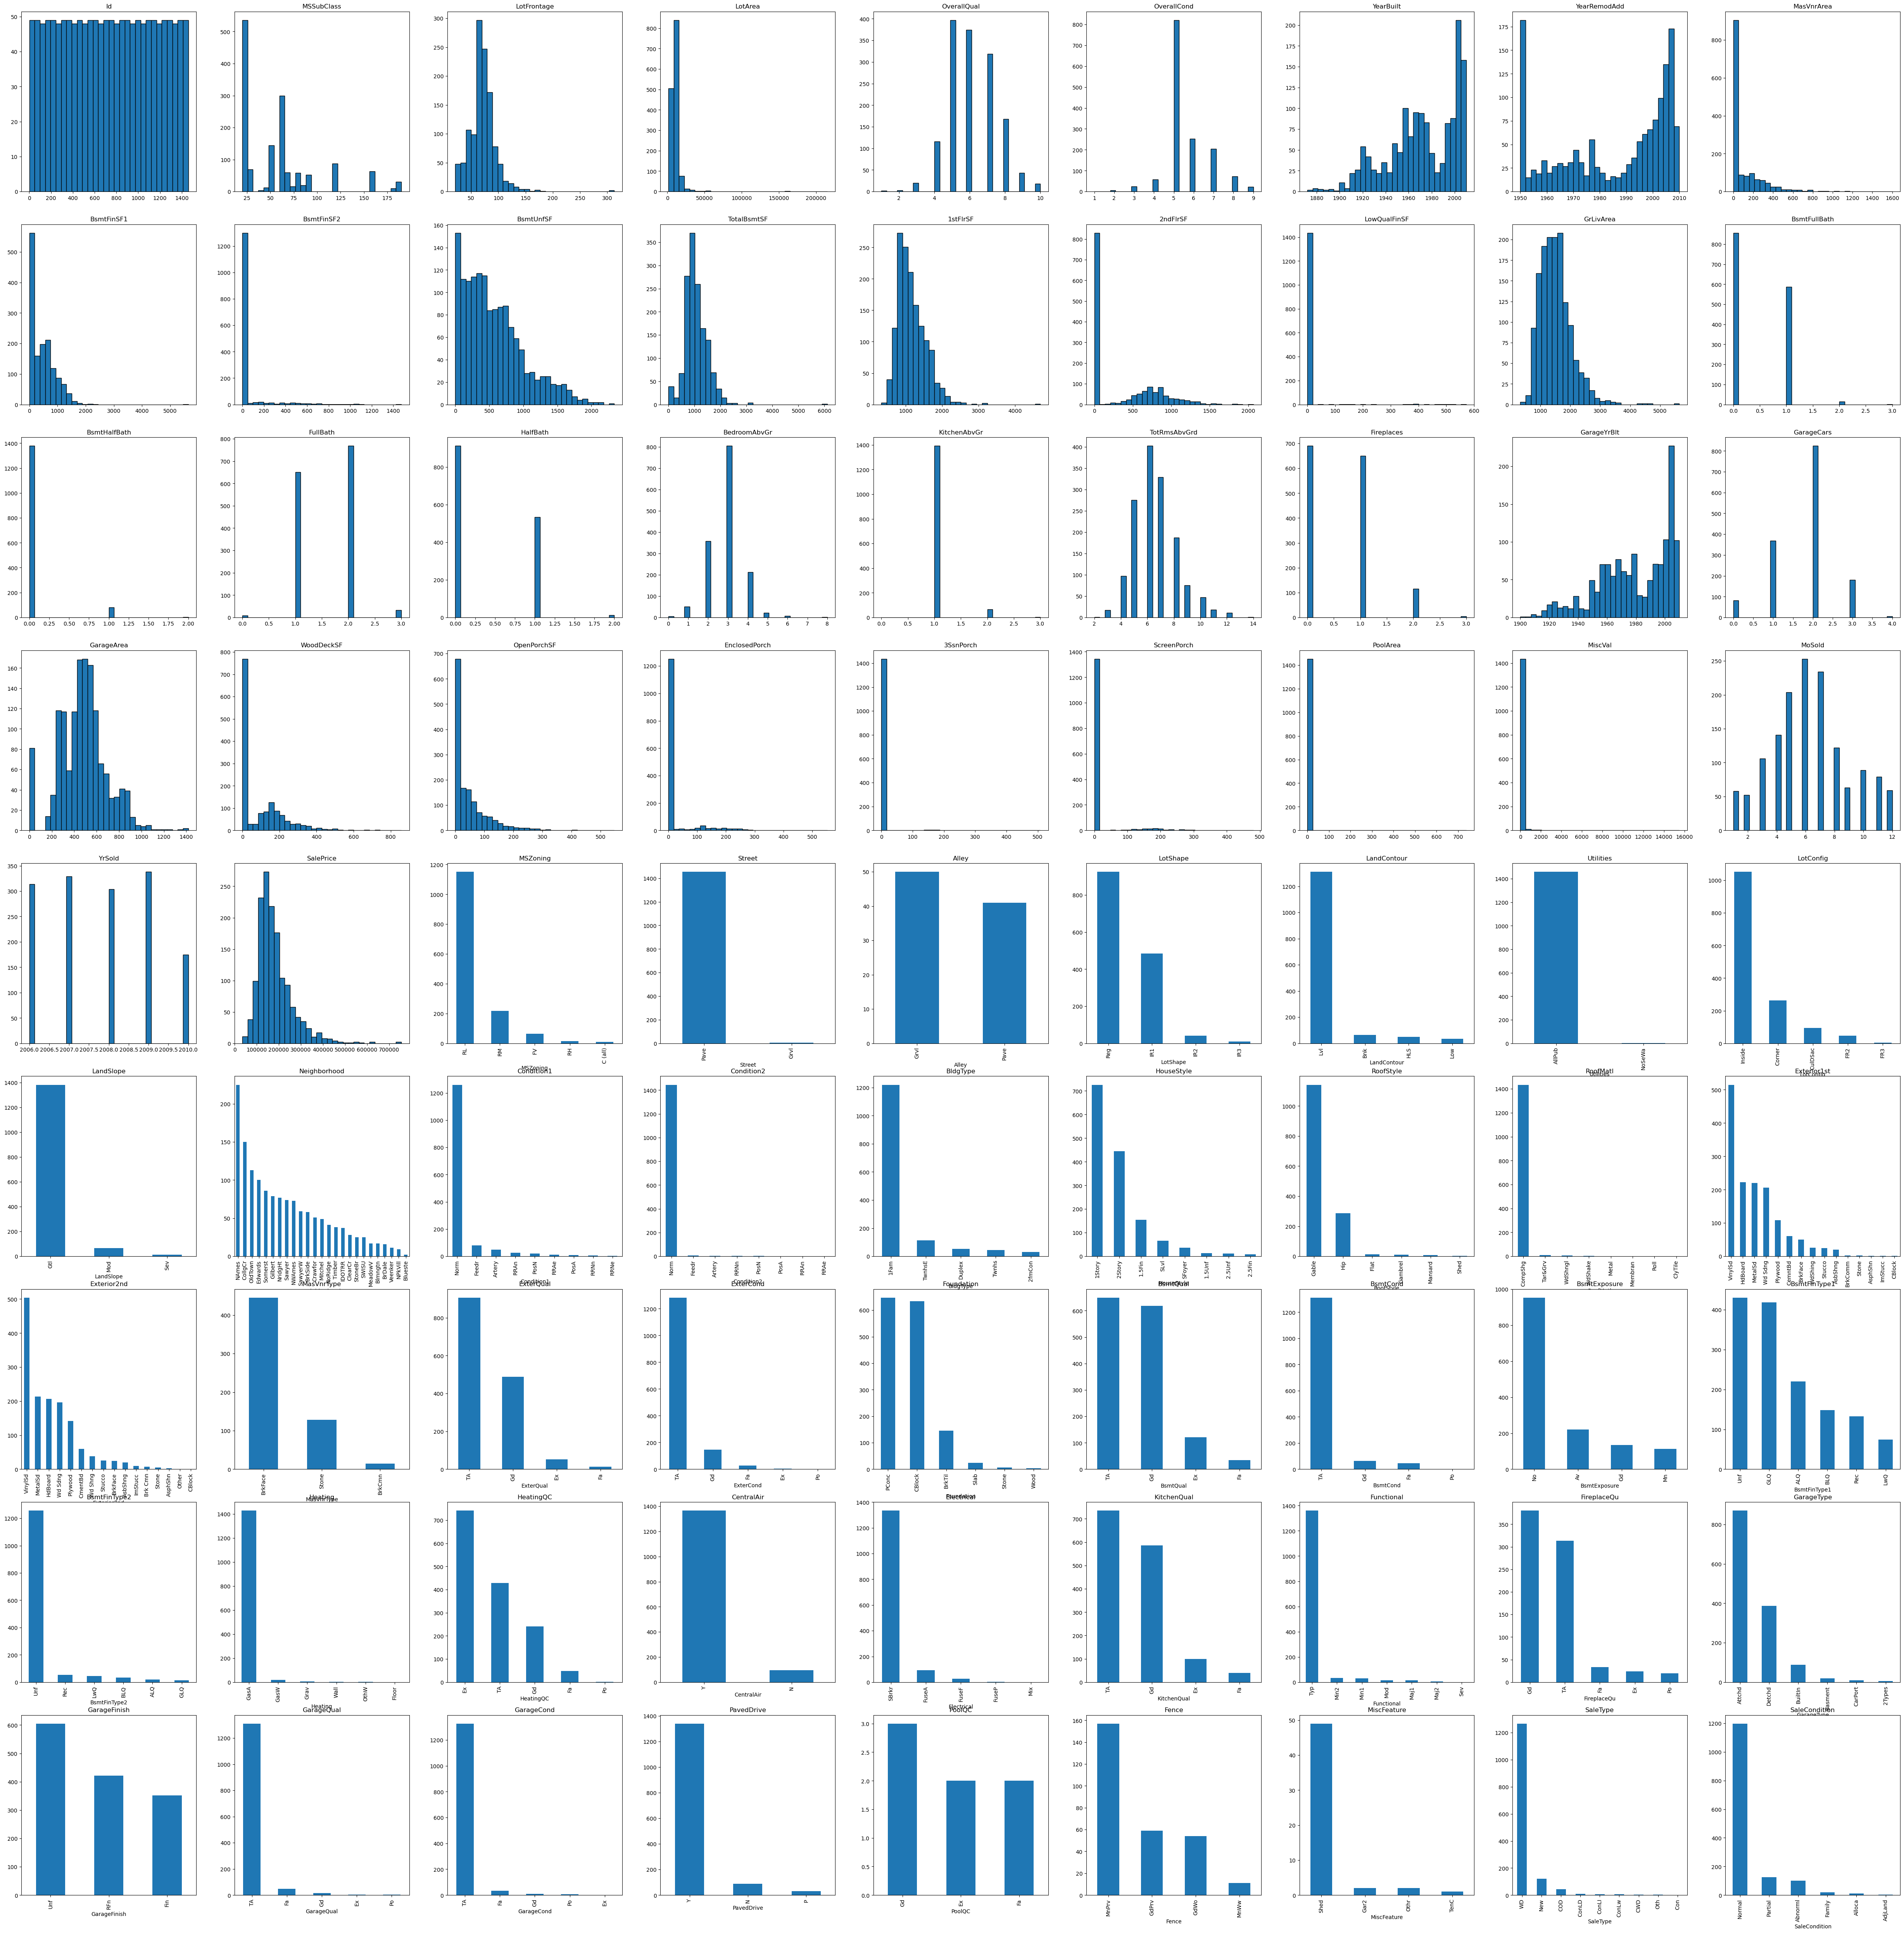

In [17]:
def visualize_dataframe_distributions(df):
    # Filtering columns by data type
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    n = len(df.columns)  # Total number of columns
    side_length = int(np.ceil(np.sqrt(n)))  # Calculating grid side length
    
    # Creating the subplot grid
    fig, axes = plt.subplots(nrows=side_length, ncols=side_length, figsize=(50, 50))
    fig.tight_layout(pad=4.0)
    
    for ax in axes.ravel():
        ax.axis('off')  # Hide all axes initially

    # Plotting numeric columns
    for i, col in enumerate(numeric_cols):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        ax.hist(df[col], bins=30, edgecolor='k')
        ax.set_title(col)
    
    # Plotting categorical columns
    for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    
    # Plotting datetime columns
    for i, col in enumerate(datetime_cols, start=len(numeric_cols) + len(categorical_cols)):
        ax = axes[i // side_length, i % side_length]
        ax.axis('on')
        df[col].value_counts().sort_index().plot(ax=ax)
        ax.set_title(col)
        
    plt.show()

visualize_dataframe_distributions(df)

In [18]:
variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']
print('Variables reales: ', variables_reales)
print('Variables categoricas: ', variables_categoricas)
print('Variables enteras: ', variables_enteras)

Variables reales:  Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')
Variables categoricas:  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Variables enteras:  Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF

In [19]:
def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[:3]
    df['specific_location'] = df['CP']
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

df.drop('Id', inplace=True, axis=1)
# df.drop(['Id', 'AguaCorriente', 'GasNatural', 'FosaSeptica'], axis=1, inplace=True)
df.dropna(inplace=True)
# #df = extract_postal_hierarchy(df)

# df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
# df['Reformada'] = df['Reformada'].astype(int)

# # Assuming you've already loaded your dataframe as df

# # Current Year
# current_year = datetime.datetime.now().year
# df['Aspect_Ratio'] = df['PerimParcela'] / df['Superficie']
# df['HighRating'] = df['RatingEstrellas'].apply(lambda x: 1 if x > 4 else 0)
# df['AgeOfHouse'] = current_year - df['FechaConstruccion']
# df['YearsSinceReform'] = current_year - df['FechaReforma']
# df['TotalRooms'] = df['Aseos'] + df['Habitaciones']
# df['AvgProximity'] = (df['ProxCarretera'] + df['ProxCallePrincipal'] + df['ProxViasTren']) / 3

variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']

#variables_enteras = variables_enteras.drop(['Precio'])
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)
#df = zscore_norm_price(df)
df = one_hot_encoding(df, variables_categoricas)

df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


               MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond   
MSSubClass            NaN          NaN      NaN          NaN          NaN  \
LotFrontage           NaN          NaN      NaN          NaN          NaN   
LotArea               NaN          NaN      NaN          NaN          NaN   
OverallQual           NaN          NaN      NaN          NaN          NaN   
OverallCond           NaN          NaN      NaN          NaN          NaN   
YearBuilt             NaN          NaN      NaN          NaN          NaN   
YearRemodAdd          NaN          NaN      NaN          NaN          NaN   
MasVnrArea            NaN          NaN      NaN          NaN          NaN   
BsmtFinSF1            NaN          NaN      NaN          NaN          NaN   
BsmtFinSF2            NaN          NaN      NaN          NaN          NaN   
BsmtUnfSF             NaN          NaN      NaN          NaN          NaN   
TotalBsmtSF           NaN          NaN      NaN          NaN          NaN   

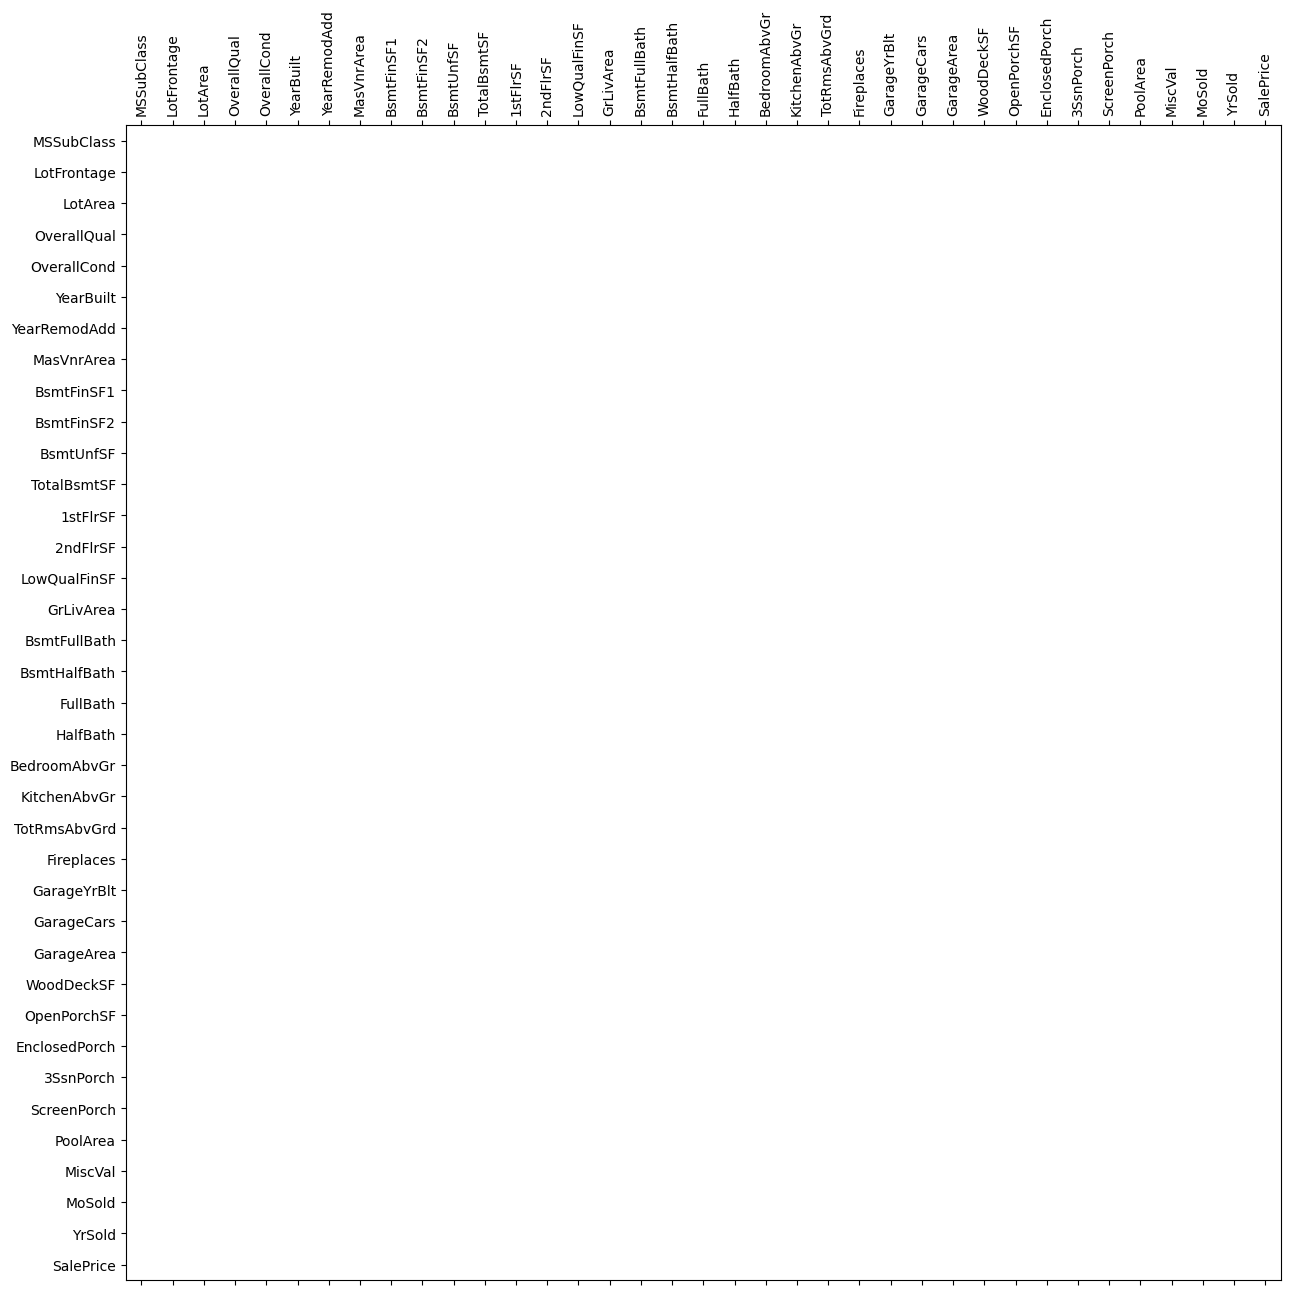

In [20]:
# plot correlation matrix of columns in the dataframe
def plot_correlation_matrix(df):
    corr = df.corr()
    #sort the correlation, place the most correlated variables next to price
    print(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

plot_correlation_matrix(df)

In [21]:

corr = df.corr()
umbral = 0.5
# Encontrar características altamente correlacionadas
caract_alta_correlacion = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > umbral:
            colname = corr.columns[i]
            caract_alta_correlacion.add(colname)
caract_alta_correlacion.remove('SalePrice')
# Eliminar características altamente correlacionadas
print(caract_alta_correlacion)
df = df.drop(caract_alta_correlacion, axis=1)
df

KeyError: 'SalePrice'

In [ ]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

train_size = 0.8
train = df.sample(frac=train_size, random_state=0)
test = df.drop(train.index)

kmeans = KMeans(n_clusters=4, random_state=42)

X_train, y_train = x_y_split(train, 'SalePrice')
X_test, y_test = x_y_split(test, 'SalePrice')

# X_train['Categoria'] = kmeans.fit_predict(X_train)
# X_train = pd.get_dummies(X_train, columns=['Categoria'], dtype=np.int64)
# X_test['Categoria'] = kmeans.fit_predict(X_test)
# X_test = pd.get_dummies(X_test, columns=['Categoria'], dtype=np.int64)

In [ ]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred

def visualize_test(y_test, y_pred, ax, model_name):
    paired = sorted(list(zip(y_test, y_pred)))
    y_test_sorted, y_pred_sorted = zip(*paired)
    y_test_sorted = zscore_norm_price_inverse(np.array(y_test_sorted))
    y_pred_sorted = zscore_norm_price_inverse(np.array(y_pred_sorted))

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    mape = mean_absolute_percentage_error(y_test_sorted, y_pred_sorted)
    # print in scientific notation format
    print('MAE: {:}'.format(mae/1000))
    print('MAPE: {:.4}'.format(mape*100))
    # plot y_test and y_pred values to visualize the model performance
    num_range = np.arange(0, len(y_test))
    ax.plot(y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()

In [ ]:
# from sklearn.preprocessing import StandardScaler

# data_train = train
# kmeans = KMeans(n_clusters=3, random_state=42)
# data_train['Categoria'] = kmeans.fit_predict(X_train)

# Q1 = data_train['Precio'].quantile(0.10)
# Q3 = data_train['Precio'].quantile(0.9)
# IQR = Q3 - Q1
# low_threshold = Q1 - 1.5 * IQR
# high_threshold = Q3 + 1.5 * IQR

# counts = data_train['Categoria'].value_counts()

# # Calcular la media de cada categoría
# means = data_train.groupby('Categoria')['Precio'].mean()

# # Imprimir los resultados
# print("Cantidad de casas en cada categoría:")
# print(counts)
# print("\nMedia de precios en cada categoría:")
# print(means)

# variables_categoricas = data_train.dtypes[data_train.dtypes == 'object'].index
# data_train = pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

# X_train, y_train = x_y_split(data_train, 'Precio')
# X_test, y_test = x_y_split(test, 'Precio')

# models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# # cols and rows for subplots according to number of models
# fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

# for i, model in enumerate(models):
#         model_name = model.__class__.__name__
#         trained_model = train_model(model, X_train, y_train)
#         y_pred = test_model(trained_model, X_test, y_test)
#         visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

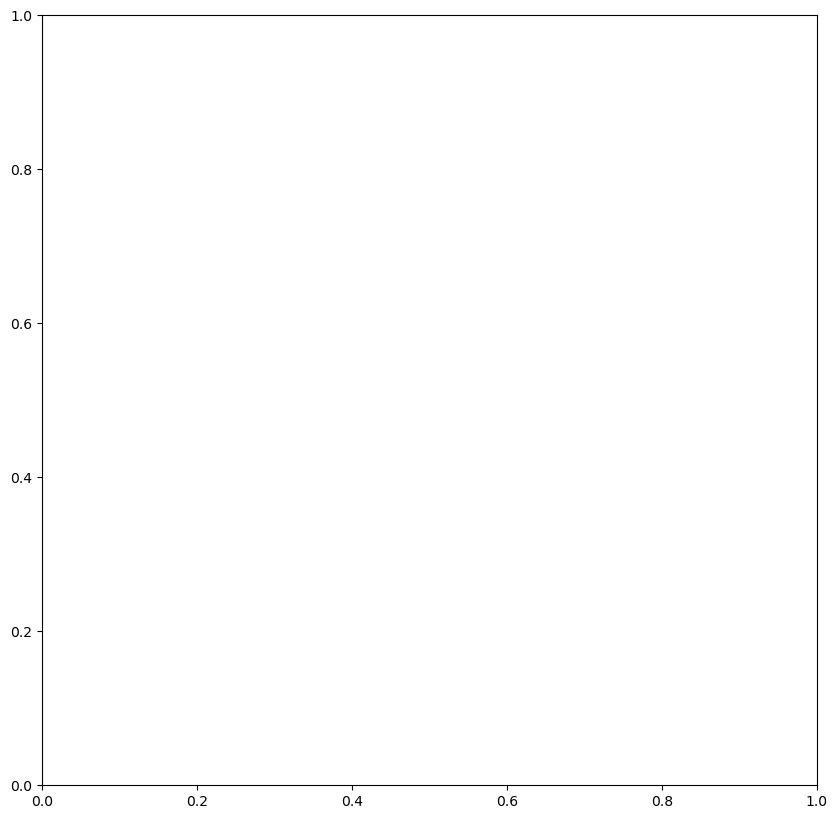

In [ ]:
best_combination = {'recall': 0, 'model': None, 'norm': None, 'sampling': None, 'trained_model': None}
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)

MAE: 84.86608890874102
MAPE: 23.64
MAE: 114.0965140669633
MAPE: 37.42
MAE: 117.38588265069863
MAPE: 38.76
MAE: 85.19788866665401
MAPE: 24.04
MAE: 83.91922239999998
MAPE: 23.86
MAE: 72.88462057599997
MAPE: 19.86
MAE: 64.66331622892275
MAPE: 17.91
MAE: 78.78410107208047
MAPE: 23.53


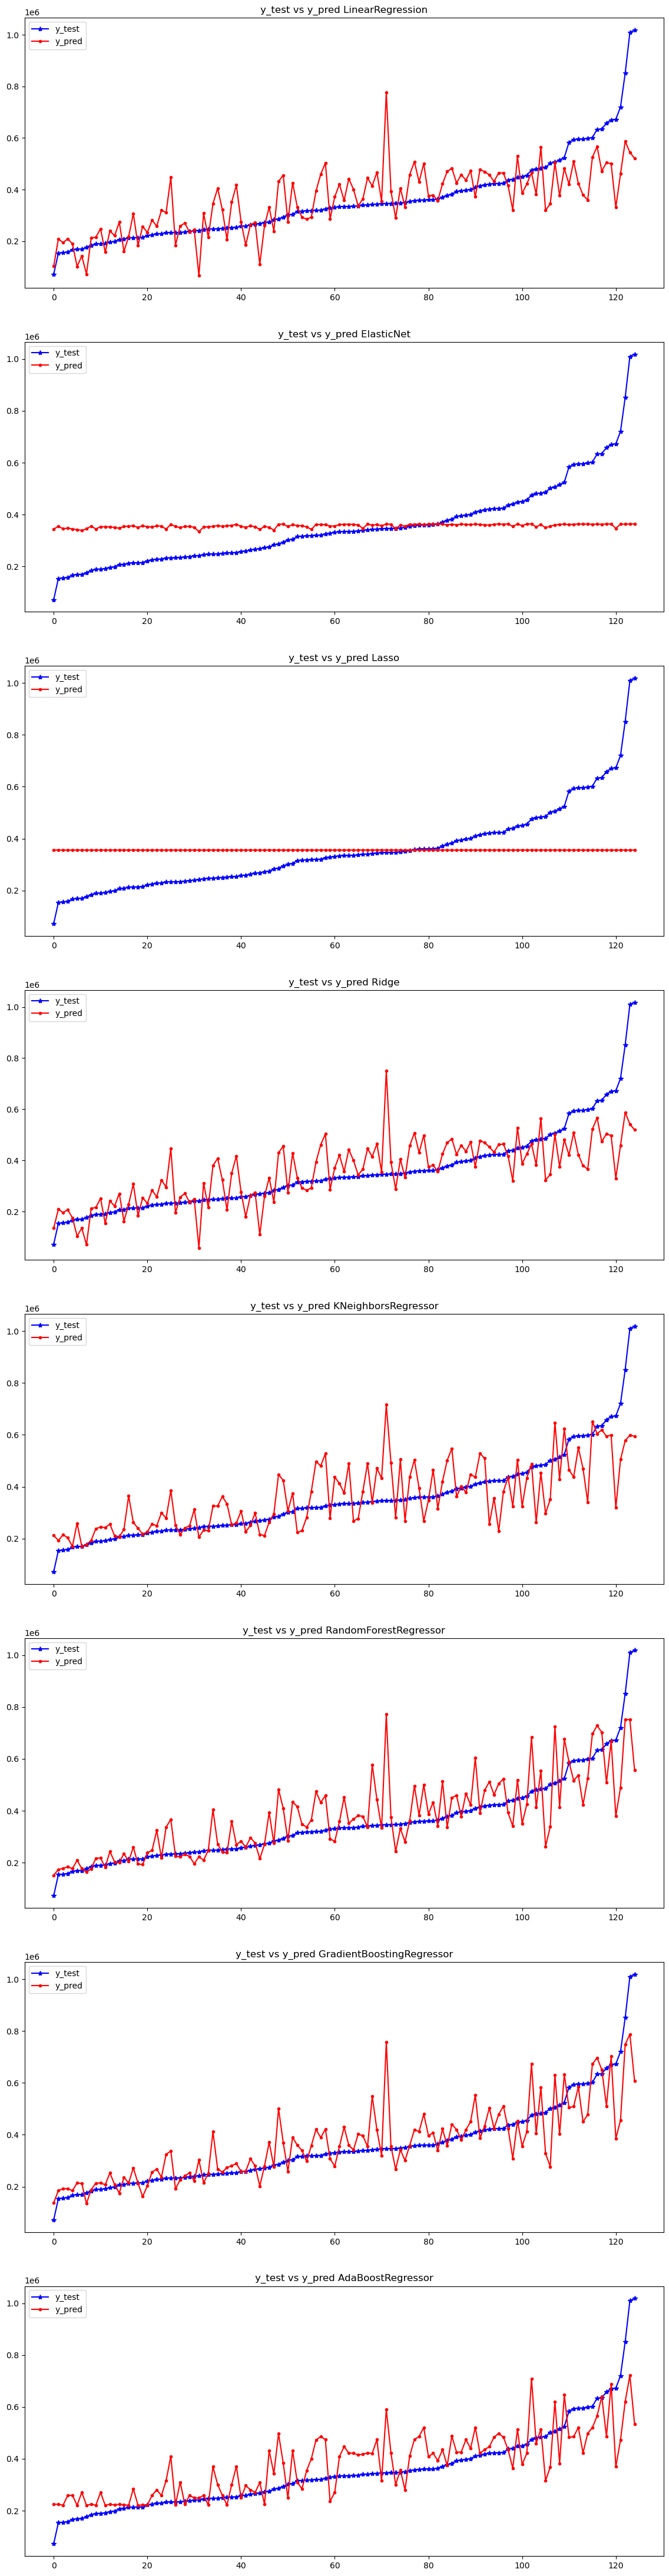

In [ ]:
models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

plt.show()


In [ ]:
grad_boost = GradientBoostingRegressor()

distributions = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 7),
    'min_samples_split': uniform(0.01, 0.2),
    'min_samples_leaf': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=10000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


KeyboardInterrupt: 

MAE: 4.45e+04


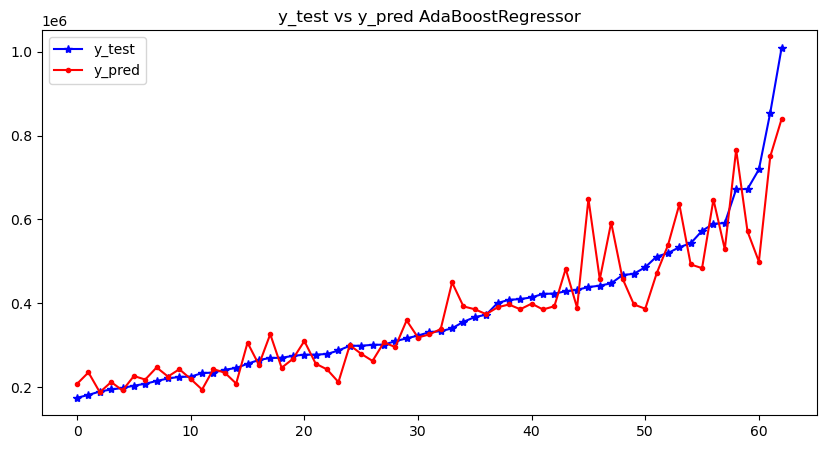

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)